In [1]:
import os
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pytorch_lightning as pl
import itertools
from matplotlib import pyplot as plt
import pyworld as pw
import pysptk as ps
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sklearn as sk

# model

In [3]:
from model.main import SplitterNet

# data

## transform

In [4]:
from data.dataset import TransSqueeze, TransChunked

## dataset

In [5]:
from data.dataset import JVSDataset

# 入力確認

In [6]:
model = SplitterNet()
model.test_input()

encoder out *2
torch.Size([64, 64, 4, 4])
decoder out
torch.Size([64, 1, 32, 32])


# eval

In [7]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [8]:
import glob
pa = glob.glob("logs/lightning_logs/version_164/checkpoints/epoch=*.ckpt")[-1]

In [9]:
model = model.load_from_checkpoint(pa)

In [10]:
model.eval()

SplitterNet(
  (content_encoder): ContentEncoder(
    (lr): GLU(dim=1)
    (conv1): Conv2d(1, 16, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 32, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 64, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 64, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(32, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 1), bias=False)
  )
  (attribute_encoder): AttributeEncoder(
    (lr): GLU(dim=1)
    (conv1): Conv2d(1, 16, kernel_size=(1, 9),

In [11]:
root = os.path.join("../",  'jvs_r9y9_ver1')
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])

In [12]:
x = torchaudio.load(wav_paths.collect_files()[101])[0]
tmp = torchaudio.load(wav_paths.collect_files()[301])[0][:, :200557]
print(x.shape)
print(tmp.shape)

torch.Size([1, 200557])
torch.Size([1, 200557])


In [13]:
def ex_mc(x):
    f0, sp, ap = pw.wav2world(x.squeeze(0).to(torch.double).numpy(), 24000)
    mc = ps.sp2mc(sp, order=31, alpha=ps.util.mcepalpha(24000))
    mc = torch.from_numpy(mc.T)
    return mc, f0, sp, ap

In [14]:
def synth(mc, f0, ap):
    mc = mc.T.numpy()
    sp = ps.mc2sp(mc, alpha=ps.util.mcepalpha(24000), fftlen=1024)
    sp = sp.astype(np.double)[:len(f0)]
    print(sp)
    return pw.synthesize(f0, sp, ap, 24000)

## 元音声の再合成

In [15]:
x_mc, x_f0, x_sp, x_ap = ex_mc(x)
xx = synth(x_mc, x_f0, x_ap)

[[3.43263472e-07 3.38804166e-07 3.27037883e-07 ... 8.59406536e-10
  8.60750018e-10 8.61197580e-10]
 [2.83185086e-08 2.80881946e-08 2.74722759e-08 ... 4.84565467e-10
  4.84599612e-10 4.84611025e-10]
 [1.73742962e-07 1.73785936e-07 1.73964547e-07 ... 7.16355213e-10
  7.15567887e-10 7.15305561e-10]
 ...
 [5.86826423e-08 5.81386119e-08 5.66810528e-08 ... 1.01183036e-09
  1.01121063e-09 1.01100373e-09]
 [1.32388387e-06 1.32359478e-06 1.32329237e-06 ... 1.90479612e-09
  1.91206395e-09 1.91449544e-09]
 [6.17626188e-08 6.15196152e-08 6.08648116e-08 ... 5.52877538e-10
  5.51500352e-10 5.51041353e-10]]


In [16]:
import IPython.display
IPython.display.Audio(xx, rate=24000)

(1, 200640)


/tmp/ipykernel_3410443/2825384265.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")


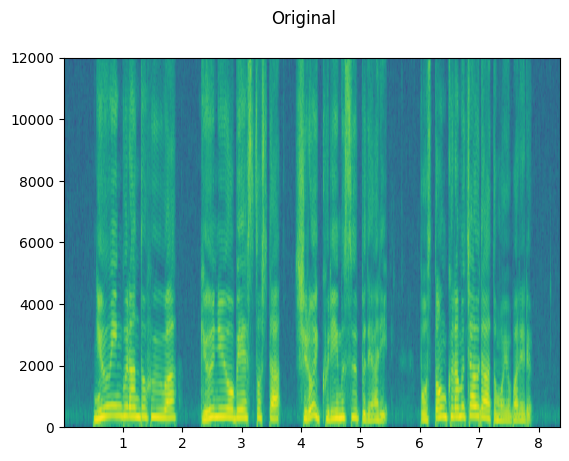

In [17]:
plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")

In [18]:
tmp_mc, tmp_f0, tmp_sp, tmp_ap = ex_mc(tmp)
tmptmp = synth(tmp_mc, tmp_f0, tmp_ap)

[[1.71995421e-06 1.69807122e-06 1.63989314e-06 ... 3.08206483e-10
  3.08842122e-10 3.09054534e-10]
 [6.07747060e-06 6.00899226e-06 5.83045756e-06 ... 1.62694691e-09
  1.63142819e-09 1.63292658e-09]
 [2.37148524e-07 2.37388171e-07 2.38099966e-07 ... 1.01614936e-09
  1.01803789e-09 1.01866907e-09]
 ...
 [2.16193247e-02 2.13635429e-02 2.06947457e-02 ... 1.54805744e-06
  1.54603760e-06 1.54536385e-06]
 [2.86748375e-02 2.86719221e-02 2.86806062e-02 ... 1.87830024e-06
  1.87998208e-06 1.88054344e-06]
 [3.95433320e-02 3.96577240e-02 3.99910544e-02 ... 1.14337026e-06
  1.14451398e-06 1.14489601e-06]]


In [19]:
import IPython.display
IPython.display.Audio(tmptmp, rate=24000)

(1, 200640)


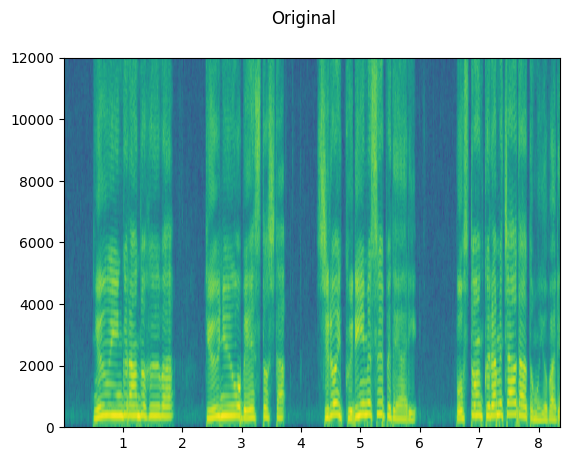

In [20]:
plot_specgram(torch.tensor([tmptmp]), sample_rate=24000, title="Original")

## 元音声の変換再合成

In [21]:
y_mc = model(x_mc.unsqueeze(0).unsqueeze(0).to(torch.float), x_mc.unsqueeze(0).unsqueeze(0).to(torch.float)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [22]:
abs(x_mc).max()

tensor(10.0126, dtype=torch.float64)

In [23]:
abs(y_mc).max()

tensor(12.9680)

In [24]:
yy = synth(y_mc, x_f0, x_ap)

[[8.95472467e-01 4.26889032e-01 5.16483784e-02 ... 3.97591376e-17
  3.83265600e-17 3.78602684e-17]
 [6.41309440e-01 3.09034646e-01 3.85549292e-02 ... 9.07302981e-18
  8.70795944e-18 8.58947740e-18]
 [1.89358521e+02 6.90439301e+01 3.86567163e+00 ... 4.65881165e-15
  4.53700916e-15 4.49709146e-15]
 ...
 [4.85131035e+01 1.93570805e+01 1.40113449e+00 ... 6.25333889e-15
  6.08614730e-15 6.03137857e-15]
 [6.76259756e-01 3.26029778e-01 4.06372473e-02 ... 1.62106843e-14
  1.57869188e-14 1.56480392e-14]
 [4.55497551e+00 2.04741263e+00 2.09060952e-01 ... 2.05315903e-16
  1.97934447e-16 1.95531693e-16]]


In [25]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 200640)


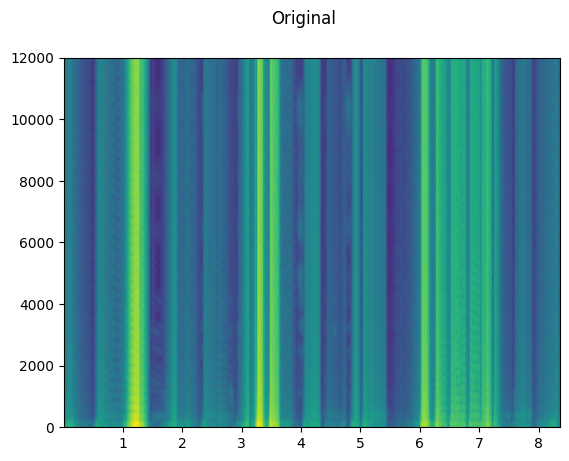

In [26]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")

In [27]:
import IPython.display
IPython.display.Audio("onsei/nanka.wav")